# Twitter Messages Data Analysis
Code link: https://github.com/hennypurwadi/twitter_analysis

### Collect Tweets from particular geocode location in Google map
https://www.google.com/maps/place/Taiwan/@24.8953179,121.5280722,10.25z/data=!4m5!3m4!1s0x346ef3065c07572f:0xe711f004bf9c5469!8m2!3d23.69781!4d120.960515

In [1]:
!pip3 install snscrape
!pip install tweepy
!pip install wordcloud
!pip install warnings-plugin

In [2]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import string
import snscrape.modules.twitter as sntwitter
import tweepy
import unicodedata
import random
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.util import bigrams
from nltk.util import trigrams
from nltk.util import ngrams
import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\envs\DLBDSEDA02\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Collect Tweets Without Twitter Developer Account /API: with snscrape

# 
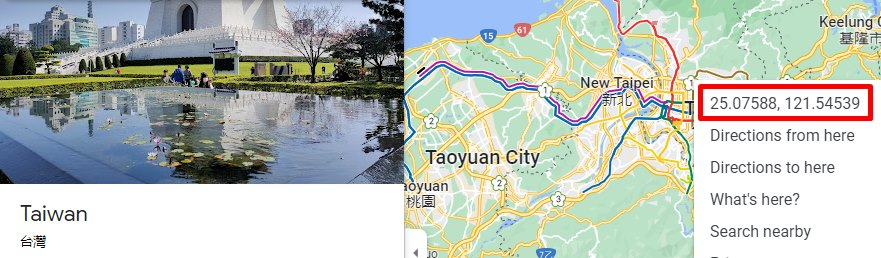

In [3]:
#Create and append to csv file and then write tweets into csv file
tweet_data = open('Taipei_tweets_sns.csv', 'a', newline='', encoding='utf8')
csv.writer(tweet_data).writerow(['username','tweet','hashtags']) 

#Radius around 50 km around particular geocode
max_tweets = 40000
for n,tweet in enumerate(sntwitter.TwitterSearchScraper('geocode:25.07588,121.54539,50km \
        + since:2022-08-01 until:2022-08-05 lang:en -filter:links -filter:replies').get_items()):
    
    if n > max_tweets:
        break
    csv.writer(tweet_data).writerow([tweet.user.username, tweet.content, tweet.hashtags])      
tweet_data.close()

In [4]:
df = pd.read_csv('Taipei_tweets_sns.csv')
df = df.dropna(subset = ['hashtags']) #Only use tweets which contained hashtags
df.head()

,username,tweet,hashtags
4,RudolfEmily3,1goonrich Sheesherc KingMessiah_BSC #kingmessi...,['kingmessiah']
9,fipsyfip,Musk says that that the only two publicly trad...,['tesla']
11,SHIBUYAENNI,"This account is Tweetbot, I don't use it. #Twe...",['Tweetbot']
16,fipsyfip,#Tesla #TSLA “Ultimately I think we’ll end up ...,"['Tesla', 'TSLA']"
17,fipsyfip,#tesla #TSLA Musk says there’s still a “host o...,"['tesla', 'TSLA']"


In [5]:
len(df)

293

### Remove emojis from username
Can't clean username like make Capital letter become lowercase etc, since Capital letter etc is unique part of the name.

Only remove emojis from username.

In [6]:
emoji_pattern = re.compile("["
                        "\U0001F600-\U0001F64F"  # emoticons
                        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        "\U0001F300-\U0001F5FF"  # pictographs, symbols 
                        "\U0001F700-\U0001F77F"  # alchemical symbols
                        "\U0001F680-\U0001F6FF"  # transport & map symbols
                        "\U0001FA00-\U0001FA6F"  # Chess Symbols
                        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                        "\U00002702-\U000027B0"  # Dingbats
                        "\U0001F1E0-\U0001F1FF"  # flags (iOS)   
                        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs                        
                        "\U000024C2-\U0001F251" 
                        "]+", flags=re.UNICODE)  

def delete_emoji(string):
    return emoji_pattern.sub(r'', string)

df['username_no_emoji'] = df['username'].apply(delete_emoji)
df[['username','username_no_emoji']].head()

,username,username_no_emoji
4,RudolfEmily3,RudolfEmily3
9,fipsyfip,fipsyfip
11,SHIBUYAENNI,SHIBUYAENNI
16,fipsyfip,fipsyfip
17,fipsyfip,fipsyfip


## 1. Entity analysis to find 5 most active users.

In [7]:
#df['user'].unique()
userlist = df['username_no_emoji'].value_counts()
most_active_users = userlist.head(5)
most_active_users

YimouLee          24
WilliamYang120    24
tmj_twn_jobs      14
fipsyfip          13
SHIBUYAENNI       11
Name: username_no_emoji, dtype: int64

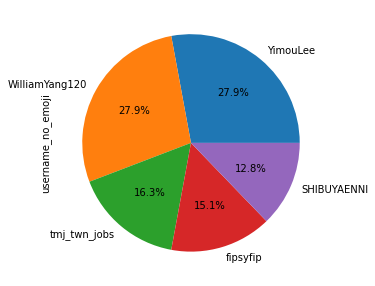

In [8]:
plot_users=most_active_users.plot.pie(autopct='%1.1f%%', figsize=(5, 5))
plt.rc('axes', unicode_minus=False)
plt.savefig("MostActiveUser_chart.jpeg",transparent=False, bbox_inches='tight',pad_inches=0.1)

## 2. Entity analysis to find 5 most used hastags

### Lite Cleaning for hashtags
Cleaning hashtags to get 5 most prevalent ones is lite cleaning

In [9]:
#Functun to convert to str
def lightclean(hashtags_data):  
    hashtags_data = str(hashtags_data).lower() #make str
    return hashtags_data

df['Cleaned_Hashtags'] = df['hashtags'].apply(lightclean)

htag_Texts_Cleaned=df['Cleaned_Hashtags'].values
htag_Texts_Cleaned=str(htag_Texts_Cleaned)
htag_Texts_Cleaned = re.sub(r'[^a-z A-Z]', ' ',htag_Texts_Cleaned)
htag_Texts_Cleaned= re.sub(r' +', ' ', htag_Texts_Cleaned)
htag_Texts_Cleaned= re.sub(r' text', ' ', htag_Texts_Cleaned) #remove 'text'
htag_Texts_Cleaned= re.sub(r' indices', ' ', htag_Texts_Cleaned) #remove 'indices'
print("Cleaned hashtags:" + "\n" + htag_Texts_Cleaned)

Cleaned hashtags:
 kingmessiah tesla tweetbot tesla tsla tesla tsla tsla tesla tesla tsla tesla tsla tesla tsla codinglife softwareengineer devlog life coding coffeelover tesla tsla tesla tsla tesla tsla tesla tsla tesla tsla tesla tsla seneca stoicism chinataiwancrisis nancypelosi breaking swift android twitter china america taiwan taiwanchinaconflict taiwancivilianwanttosay newprofilepic nftcommmunity ecommerce blocked taiwan taiwan taiwan langtwt taiwan rootmeta lit blocked qanda qanda qanda china taiwan qanda twitter tweets qanda qanda tinagoldsteinmonth qanda taiwan taiwan taiwan abc taiwan us china taiwan metaverse playtoearn nfts alessandropertiniyou marcusaurelius stoicism taiwan china semiconductors china taiwan taiwan taiwan tweetbot nannystate overstep taiwan taiwanstraitscrisis taipei engineering thetrad innergame mindfulness milebiblexemiliopucci lp liquidity breaking engineering taipei taiwan taiwan taiwan taiwan taiwan fear fear fearofgod fear china taiwan taiwan taipei 

### Counting the number of hastags

In [10]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    return counts

hashtag_count = word_count(htag_Texts_Cleaned)
print(hashtag_count)

{'kingmessiah': 1, 'tesla': 13, 'tweetbot': 11, 'tsla': 12, 'codinglife': 1, 'softwareengineer': 1, 'devlog': 1, 'life': 1, 'coding': 2, 'coffeelover': 1, 'seneca': 1, 'stoicism': 8, 'chinataiwancrisis': 2, 'nancypelosi': 5, 'breaking': 2, 'swift': 3, 'android': 1, 'twitter': 3, 'china': 18, 'america': 1, 'taiwan': 102, 'taiwanchinaconflict': 1, 'taiwancivilianwanttosay': 1, 'newprofilepic': 1, 'nftcommmunity': 1, 'ecommerce': 1, 'blocked': 4, 'langtwt': 7, 'rootmeta': 1, 'lit': 1, 'qanda': 7, 'tweets': 1, 'tinagoldsteinmonth': 2, 'abc': 1, 'us': 4, 'metaverse': 1, 'playtoearn': 1, 'nfts': 1, 'alessandropertiniyou': 1, 'marcusaurelius': 5, 'semiconductors': 1, 'nannystate': 1, 'overstep': 1, 'taiwanstraitscrisis': 1, 'taipei': 13, 'engineering': 8, 'thetrad': 1, 'innergame': 1, 'mindfulness': 1, 'milebiblexemiliopucci': 1, 'lp': 1, 'liquidity': 1, 'fear': 3, 'fearofgod': 1, 'rocarmdforces': 1, 'krotime': 1, 'eternals': 2, 'shangchi': 1, 'phase': 1, 'deathstranding': 1, 'sol': 1, 'solgi

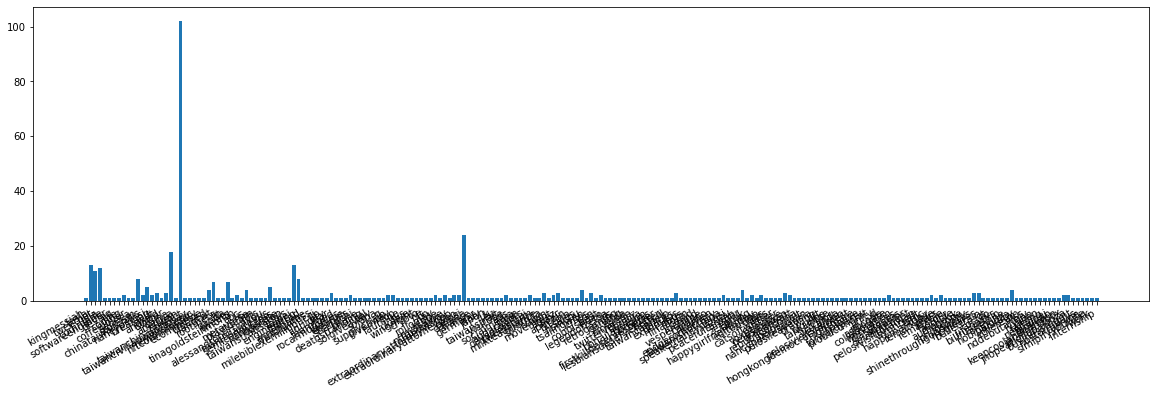

In [11]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(20, 6))
ax1.bar(hashtag_count.keys(), hashtag_count.values())
fig.autofmt_xdate()
plt.savefig('hashtag_count_graph.jpeg')
plt.show()

In [12]:
MostPopularHashtags = sorted(hashtag_count, key=hashtag_count.get, reverse=True)[:5]
#' '.join(MostPopularHashtags)
MostPopularHashtags

['taiwan', 'pelosi', 'china', 'tesla', 'taipei']

In [13]:
#Convert list to str

MostPopularHashtags_str = ''
i = 0
for x in MostPopularHashtags:
    i = i+1
    if i < 5:
        MostPopularHashtags_str += '#'+ x + ', '
    else:
        MostPopularHashtags_str += '#'+ x
    
print("5 Most popular hastags are : " + MostPopularHashtags_str)

5 Most popular hastags are : #taiwan, #pelosi, #china, #tesla, #taipei


In [14]:
TopPopularHashtags = sorted(hashtag_count, key=hashtag_count.get, reverse=True)[:1]
TopPopularHashtags_str = ' '.join(str(e) for e in TopPopularHashtags) #convert list to str
TopPopularHashtags_str
print("Top popular hastags is : " + TopPopularHashtags_str)

Top popular hastags is : taiwan


## 3. Entity analysis to extract five most prevalent topics in the tweets

### Preprocessing, Cleaning with regex
Make the text lowercase, remove line breaks, punctuation, usernames, url, extra spaces, etc

In [15]:
def cleaning(tweets_data):   
    tweets_data = str(tweets_data).lower() #Make the text lowercase.
    tweets_data = re.sub(r'#[A-Za-z0–9]+', '', tweets_data) #remove hashtags
    tweets_data=re.sub(r'@[A-Za-z0–9]+', '',tweets_data) #remove usernames    
    tweets_data=re.sub(r'@\w+', ' ', tweets_data) #remove usernames
    tweets_data= re.sub(r'\b\w{1}\b', '', tweets_data) #remove stopwords   
    tweets_data = re.sub(r'&(?![A-Za-z]+[0-9]*;|#[0-9]+;|#x[0-9a-fA-F]+;)', '', tweets_data)
    tweets_data = re.sub(r'&amp', '', tweets_data) 
    tweets_data = re.sub('\n', '', tweets_data) #Remove line breaks.
    tweets_data = re.sub('[%s]' % re.escape(string.punctuation), '', tweets_data) #remove punctuation
    tweets_data = re.sub('\[.*?\]', '', tweets_data)
    tweets_data=re.sub(r'http\S+', ' ', tweets_data) #remove all Url
    tweets_data = re.sub(r'https?:\/\/.*[\r\n]*', '', tweets_data) #remove website
    tweets_data = re.sub('https?://\S+|www\.\S+', '', tweets_data)  #remove all websites 
    tweets_data = re.sub(r' +', ' ', tweets_data) #remove extra space
    tweets_data = re.sub('<.*?>+', '', tweets_data)    
    tweets_data = re.sub('\w*\d\w*', '', tweets_data)
    tweets_data = re.sub(r'^RT[\s]+', '', tweets_data)    
    tweets_data = re.sub(r'[^a-z A-Z]', ' ',tweets_data) #Remove all not characters
    tweets_data = re.sub(emoji_pattern, '', tweets_data)#remove emojis
          
    return tweets_data

df['clean1_tweet'] = df['tweet'].apply(cleaning)
df_cleaned_tweets=df[['tweet','clean1_tweet']]
df_cleaned_tweets.head(20)

,tweet,clean1_tweet
4,1goonrich Sheesherc KingMessiah_BSC #kingmessi...,sheesherc kingmessiahbsc bro that coin is res...
9,Musk says that that the only two publicly trad...,musk says that that the only two publicly trad...
11,"This account is Tweetbot, I don't use it. #Twe...",this account is tweetbot don use it
16,#Tesla #TSLA “Ultimately I think we’ll end up ...,ultimately think we ll end up building or ...
17,#tesla #TSLA Musk says there’s still a “host o...,musk says there still host of problems lef...
18,#TSLA #Tesla Musk says that the Model Y is tra...,musk says that the model is tracking to be te...
19,#tesla #TSLA Elon Musk is now on stage and say...,elon musk is now on stage and says tesla mig...
20,#tesla #TSLA Viecha announces preliminary resu...,viecha announces preliminary results and the ...
21,#tesla #TSLA Tesla Holders Approve 3-to-1 Stoc...,tesla holders approve to stock split at share...
27,🌞☕️👩🏻‍💻\nMornings are for coffee and coding.\n...,mornings are for coffee and coding


### Remove stopwords with nltk

In [16]:
stopwords = nltk.corpus.stopwords.words('english') 
df['clean2_tweet'] = df['clean1_tweet'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stopwords))

df_cleaned_tweets=df[['tweet','clean2_tweet']]
df_cleaned_tweets.head()

,tweet,clean2_tweet
4,1goonrich Sheesherc KingMessiah_BSC #kingmessi...,sheesherc kingmessiahbsc bro coin respectfly l...
9,Musk says that that the only two publicly trad...,musk says two publicly traded securities owns ...
11,"This account is Tweetbot, I don't use it. #Twe...",account tweetbot use
16,#Tesla #TSLA “Ultimately I think we’ll end up ...,ultimately think end building gigafactories mu...
17,#tesla #TSLA Musk says there’s still a “host o...,musk says still host problems left solve spool...


### Stemming with nltk

In [17]:
stm = PorterStemmer()
df['clean3_tweet'] = df['clean2_tweet'].apply(
    lambda x: " ".join([stm.stem(word) for word in x.split()]))

df_cleaned_tweets=df[['tweet','clean3_tweet']]
df_cleaned_tweets.head()

,tweet,clean3_tweet
4,1goonrich Sheesherc KingMessiah_BSC #kingmessi...,sheesherc kingmessiahbsc bro coin respectfli l...
9,Musk says that that the only two publicly trad...,musk say two publicli trade secur own tesla tw...
11,"This account is Tweetbot, I don't use it. #Twe...",account tweetbot use
16,#Tesla #TSLA “Ultimately I think we’ll end up ...,ultim think end build gigafactori musk say cla...
17,#tesla #TSLA Musk says there’s still a “host o...,musk say still host problem left solv spool au...


### Lemitization with nltk

In [18]:
##lemmatization to bring the words in their root form  
lem = WordNetLemmatizer()
df['cleaned_tweet'] = df['clean3_tweet'].apply(
    lambda x: " ".join([lem.lemmatize(word) for word in x.split()]))
df_cleaned_tweets=df[['tweet','cleaned_tweet']]
df_cleaned_tweets.head()

,tweet,cleaned_tweet
4,1goonrich Sheesherc KingMessiah_BSC #kingmessi...,sheesherc kingmessiahbsc bro coin respectfli l...
9,Musk says that that the only two publicly trad...,musk say two publicli trade secur own tesla tw...
11,"This account is Tweetbot, I don't use it. #Twe...",account tweetbot use
16,#Tesla #TSLA “Ultimately I think we’ll end up ...,ultim think end build gigafactori musk say cla...
17,#tesla #TSLA Musk says there’s still a “host o...,musk say still host problem left solv spool au...


### Vectorize cleaned tweets with CountVectorizer with ngrame_range

ngram_range of (1, 1) means only unigrams.
(1, 2) means unigrams and bigrams.
(1, 3) means unigrams, bigrams, and trigrams.
(2, 2) means only bigrams. 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [19]:
countv = CountVectorizer(min_df=1,max_df=0.95,ngram_range=(1,3),stop_words='english')
countv_tweet = countv.fit_transform(df['cleaned_tweet'])
countv_tweet

<293x6702 sparse matrix of type '<class 'numpy.int64'>'
	with 8732 stored elements in Compressed Sparse Row format>

In [20]:
countv_tweet.shape

(293, 6702)

### Vectorize cleaned tweets with Tf-IDF with ngram_range

In [21]:
tfidf = TfidfVectorizer(min_df=1 ,max_df=0.95, ngram_range=(1,3),stop_words='english')
tfidf_tweet = tfidf.fit_transform(df['cleaned_tweet'])
tfidf_tweet

<293x6702 sparse matrix of type '<class 'numpy.float64'>'
	with 8732 stored elements in Compressed Sparse Row format>

## Topic extraction with LDA (Latent Dirichlet Allocation) with Countvectorizer

In [22]:
LDA_countv = LatentDirichletAllocation(n_components=5,random_state=42)
LDA_countv.fit(countv_tweet)

LatentDirichletAllocation(n_components=5, random_state=42)

In [23]:
#len(LDA_countv.components_[0])
LDA_countv.components_

array([[1.19999772, 1.19999772, 1.19999772, ..., 1.19999587, 1.19999587,
        1.19999706],
       [0.20000069, 0.20000069, 0.20000069, ..., 0.20000125, 0.20000125,
        0.20000088],
       [0.20000053, 0.20000053, 0.20000053, ..., 0.20000097, 0.20000097,
        0.20000069],
       [0.20000057, 0.20000057, 0.20000057, ..., 0.20000103, 0.20000103,
        0.20000073],
       [0.20000049, 0.20000049, 0.20000049, ..., 0.20000089, 0.20000089,
        0.20000063]])

In [24]:
eachtopic = LDA_countv.components_[0]
eachtopic.argsort()

array([2054,  447, 3173, ..., 2787, 3490, 5539], dtype=int64)

In [25]:
#eachtopic[183]
# Top 5 words for this topic:
eachtopic.argsort()[-5:]

array([2810, 6242, 2787, 3490, 5539], dtype=int64)

In [26]:
word_top = eachtopic.argsort()[-5:]
for index in word_top:
    print(countv.get_feature_names()[index])

know
use
keyword
ministri
taiwan


In [27]:
for index,topic in enumerate(LDA_countv.components_):
    print(f'Most prevalent topic #{index}'+ ': ')
    print([countv.get_feature_names()[i] for i in topic.argsort()[-10:]])

Most prevalent topic #0: 
['come', 'like', 'need', 'drill', 'report', 'know', 'use', 'keyword', 'ministri', 'taiwan']
Most prevalent topic #1: 
['shibuyaennithat', 'account', 'realli', 'use', 'learn', 'like', 'taiwan', 'china', 'look', 'love']
Most prevalent topic #2: 
['think', 'ministri', 'receiv', 'chine', 'year', 'peopl', 'say', 'twitter', 'china', 'taiwan']
Most prevalent topic #3: 
['countri', 'job like', 'appli', 'trade', 'follow', 'china', 'job', 'like', 'twitter', 'taiwan']
Most prevalent topic #4: 
['day', 'line', 'sourc', 'chine', 'friend', 'visit', 'time', 'pelosi', 'twitter', 'taiwan']


In [28]:
topic_lda_cv = LDA_countv.transform(countv_tweet)
topic_lda_cv[0].argmax()
topic_lda_cv.argmax(axis=1)
df['Topic_lda_cv'] = topic_lda_cv.argmax(axis=1)
df[['tweet','cleaned_tweet','Topic_lda_cv']].head(40)

,tweet,cleaned_tweet,Topic_lda_cv
4,1goonrich Sheesherc KingMessiah_BSC #kingmessi...,sheesherc kingmessiahbsc bro coin respectfli l...,0
9,Musk says that that the only two publicly trad...,musk say two publicli trade secur own tesla tw...,3
11,"This account is Tweetbot, I don't use it. #Twe...",account tweetbot use,2
16,#Tesla #TSLA “Ultimately I think we’ll end up ...,ultim think end build gigafactori musk say cla...,4
17,#tesla #TSLA Musk says there’s still a “host o...,musk say still host problem left solv spool au...,0
18,#TSLA #Tesla Musk says that the Model Y is tra...,musk say model track tesla highestsel vehicl r...,2
19,#tesla #TSLA Elon Musk is now on stage and say...,elon musk stage say tesla might get close mill...,2
20,#tesla #TSLA Viecha announces preliminary resu...,viecha announc preliminari result stock split ...,2
21,#tesla #TSLA Tesla Holders Approve 3-to-1 Stoc...,tesla holder approv stock split sharehold meet,2
27,🌞☕️👩🏻‍💻\nMornings are for coffee and coding.\n...,morn coffe code,0


## Topic extraction with LDA (Latent Dirichlet Allocation) with Tf-IDF

In [29]:
LDA_tfidf = LatentDirichletAllocation(n_components=5,random_state=42)
LDA_tfidf.fit(tfidf_tweet)

LatentDirichletAllocation(n_components=5, random_state=42)

In [30]:
LDA_tfidf.components_

array([[0.31629926, 0.31629926, 0.31629926, ..., 0.20001241, 0.20001241,
        0.3424744 ],
       [0.20001054, 0.20001054, 0.20001054, ..., 0.20001192, 0.20001192,
        0.20001076],
       [0.20001087, 0.20001087, 0.20001087, ..., 0.37306855, 0.37306855,
        0.20001154],
       [0.2000109 , 0.2000109 , 0.2000109 , ..., 0.20001227, 0.20001227,
        0.2000112 ],
       [0.20001079, 0.20001079, 0.20001079, ..., 0.20001191, 0.20001191,
        0.20001088]])

In [31]:
eachtopics = LDA_tfidf.components_[0]
eachtopics.argsort()

array([ 879,  301,  216, ..., 5539,  530, 6516], dtype=int64)

In [32]:
#eachtopics[183]
# Top 5 words for this topic:
eachtopics.argsort()[-5:]

array([1046, 6519, 5539,  530, 6516], dtype=int64)

In [33]:
for index,topic in enumerate(LDA_tfidf.components_):
    print(f'Most prevalent topic #{index}'+ ': ')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-10:]]) 

Most prevalent topic #0: 
['pelosi', 'land', 'keyword', 'welocom', 'cobb best', 'cobb', 'welcom taiwan', 'taiwan', 'best', 'welcom']
Most prevalent topic #1: 
['day', 'learn', 'wait', 'use', 'account', 'love', 'account use shibuyaennithat', 'shibuyaennithat', 'use shibuyaennithat', 'account use']
Most prevalent topic #2: 
['chine', 'say', 'china', 'taiwan', 'use', 'account', 'account tweetbot', 'account tweetbot use', 'tweetbot use', 'tweetbot']
Most prevalent topic #3: 
['appli', 'wish', 'taiwan', 'fuck', 'life', 'come', 'happen', 'hello twittbot', 'twittbot', 'hello']
Most prevalent topic #4: 
['friend', 'forc', 'click link bio', 'click', 'click link', 'link bio', 'bio', 'link', 'twitter', 'taiwan']


In [34]:
topic_lda_tfidf = LDA_tfidf.transform(tfidf_tweet)
topic_lda_tfidf.shape
topic_lda_tfidf[0].round(2)
topic_lda_tfidf[0].argmax()
topic_lda_tfidf.argmax(axis=1)

array([0, 3, 2, 1, 4, 2, 2, 2, 0, 0, 4, 2, 4, 0, 3, 3, 3, 2, 4, 0, 4, 3,
       4, 4, 2, 1, 4, 2, 0, 0, 0, 4, 4, 3, 1, 3, 1, 4, 4, 2, 3, 2, 4, 2,
       3, 1, 3, 2, 1, 4, 3, 1, 1, 2, 2, 1, 1, 3, 1, 3, 4, 1, 3, 1, 4, 4,
       4, 4, 4, 4, 0, 3, 0, 4, 0, 4, 2, 2, 0, 0, 2, 1, 2, 2, 0, 4, 3, 1,
       1, 2, 1, 0, 3, 0, 3, 3, 3, 3, 2, 3, 2, 3, 1, 1, 2, 2, 2, 3, 1, 1,
       4, 3, 4, 4, 2, 1, 0, 2, 2, 4, 2, 1, 4, 3, 1, 2, 3, 0, 1, 0, 2, 4,
       3, 2, 2, 3, 4, 3, 4, 4, 0, 4, 1, 1, 1, 1, 3, 0, 2, 0, 0, 4, 1, 0,
       1, 1, 3, 4, 3, 0, 1, 1, 3, 3, 0, 0, 1, 2, 3, 3, 4, 1, 3, 0, 3, 2,
       2, 4, 1, 4, 0, 2, 4, 3, 4, 1, 0, 4, 0, 1, 1, 0, 0, 3, 1, 3, 0, 4,
       1, 4, 4, 1, 3, 0, 0, 2, 4, 1, 1, 4, 2, 1, 2, 0, 3, 3, 2, 3, 0, 2,
       4, 0, 0, 3, 4, 4, 4, 1, 4, 2, 3, 4, 3, 1, 3, 0, 4, 0, 1, 1, 0, 4,
       1, 1, 1, 3, 2, 1, 3, 1, 0, 1, 4, 2, 1, 1, 2, 1, 3, 1, 1, 1, 4, 2,
       4, 4, 0, 1, 4, 3, 2, 1, 0, 2, 4, 1, 4, 3, 2, 3, 3, 1, 3, 1, 4, 0,
       0, 0, 0, 1, 2, 3, 1], dtype=int64)

In [35]:
df['Topic_lda_tfif'] = topic_lda_tfidf.argmax(axis=1)
df[['tweet','cleaned_tweet','Topic_lda_tfif']].head(40)

,tweet,cleaned_tweet,Topic_lda_tfif
4,1goonrich Sheesherc KingMessiah_BSC #kingmessi...,sheesherc kingmessiahbsc bro coin respectfli l...,0
9,Musk says that that the only two publicly trad...,musk say two publicli trade secur own tesla tw...,3
11,"This account is Tweetbot, I don't use it. #Twe...",account tweetbot use,2
16,#Tesla #TSLA “Ultimately I think we’ll end up ...,ultim think end build gigafactori musk say cla...,1
17,#tesla #TSLA Musk says there’s still a “host o...,musk say still host problem left solv spool au...,4
18,#TSLA #Tesla Musk says that the Model Y is tra...,musk say model track tesla highestsel vehicl r...,2
19,#tesla #TSLA Elon Musk is now on stage and say...,elon musk stage say tesla might get close mill...,2
20,#tesla #TSLA Viecha announces preliminary resu...,viecha announc preliminari result stock split ...,2
21,#tesla #TSLA Tesla Holders Approve 3-to-1 Stoc...,tesla holder approv stock split sharehold meet,0
27,🌞☕️👩🏻‍💻\nMornings are for coffee and coding.\n...,morn coffe code,0


## Topic extraction with NMF (Non-Negative Matric Factorization) with Countvectorizer

In [36]:
nmf_model_cv = NMF(n_components=5, random_state=42) 
nmf_model_cv.fit(countv_tweet) 

NMF(n_components=5, random_state=42)

In [37]:
for index,topic in enumerate(nmf_model_cv.components_):
    print(f'Most prevalent topic #{index}'+ ': ')
    print([countv.get_feature_names()[i] for i in topic.argsort()[-10:]]) 

Most prevalent topic #0: 
['pelosi', 'close', 'sourc', 'missil', 'militari', 'visit', 'ministri', 'chine', 'china', 'taiwan']
Most prevalent topic #1: 
['twitter follow', 'remov', 'thailand', 'block twitter', 'intern friend', 'intern', 'block', 'follow', 'friend', 'twitter']
Most prevalent topic #2: 
['look', 'appli job', 'job like', 'like', 'amd', 'link bio', 'link', 'bio', 'job', 'appli']
Most prevalent topic #3: 
['job like', 'track', 'want', 'right', 'job', 'look', 'use', 'like', 'manag', 'keyword']
Most prevalent topic #4: 
['ministri', 'visit', 'tue', 'late tue', 'cyber', 'cyber attack', 'receiv', 'late', 'say', 'attack']


In [38]:
topic_nmf_cv = nmf_model_cv.transform(countv_tweet)
topic_nmf_cv.argmax(axis=1)
df['Topic_nmf_cv'] = topic_nmf_cv.argmax(axis=1)
df[['tweet','cleaned_tweet','Topic_nmf_cv']].head(40)

,tweet,cleaned_tweet,Topic_nmf_cv
4,1goonrich Sheesherc KingMessiah_BSC #kingmessi...,sheesherc kingmessiahbsc bro coin respectfli l...,3
9,Musk says that that the only two publicly trad...,musk say two publicli trade secur own tesla tw...,1
11,"This account is Tweetbot, I don't use it. #Twe...",account tweetbot use,3
16,#Tesla #TSLA “Ultimately I think we’ll end up ...,ultim think end build gigafactori musk say cla...,4
17,#tesla #TSLA Musk says there’s still a “host o...,musk say still host problem left solv spool au...,4
18,#TSLA #Tesla Musk says that the Model Y is tra...,musk say model track tesla highestsel vehicl r...,4
19,#tesla #TSLA Elon Musk is now on stage and say...,elon musk stage say tesla might get close mill...,4
20,#tesla #TSLA Viecha announces preliminary resu...,viecha announc preliminari result stock split ...,0
21,#tesla #TSLA Tesla Holders Approve 3-to-1 Stoc...,tesla holder approv stock split sharehold meet,4
27,🌞☕️👩🏻‍💻\nMornings are for coffee and coding.\n...,morn coffe code,0


## Topic extraction with NMF (Non-Negative Matric Factorization) with Tf-IDF

In [39]:
nmf_model_tfidf= NMF(n_components = 5, random_state=42)
nmf_model_tfidf.fit(tfidf_tweet)

NMF(n_components=5, random_state=42)

In [40]:
for index,topic in enumerate(nmf_model_tfidf.components_):
    print(f'Most prevalent topic #{index}'+ ': ')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-10:]])        

Most prevalent topic #0: 
['twitter account', 'specif', 'twitter', 'keyword', 'use', 'account', 'tweetbot use', 'tweetbot', 'account tweetbot use', 'account tweetbot']
Most prevalent topic #1: 
['greater harmoni', 'destin greater harmoni', 'destin greater', 'destin', 'harmoni', 'happen destin', 'love happen destin', 'happen destin greater', 'love', 'happen']
Most prevalent topic #2: 
['manag', 'look', 'like', 'job like', 'amd', 'bio', 'link', 'link bio', 'appli', 'job']
Most prevalent topic #3: 
['twitter account', 'specif', 'twitter', 'keyword', 'use', 'account', 'account use', 'shibuyaennithat', 'use shibuyaennithat', 'account use shibuyaennithat']
Most prevalent topic #4: 
['navi', 'ministri', 'pelosi', 'china', 'chine', 'arriv', 'arriv welcom', 'taiwan', 'welcom taiwan', 'welcom']


In [41]:
topic_nmf_tfidf = nmf_model_tfidf.transform(tfidf_tweet)
topic_nmf_tfidf.argmax(axis=1)
df['Topics_nmf_tfidf'] = topic_nmf_tfidf.argmax(axis=1)
df[['tweet','cleaned_tweet','Topics_nmf_tfidf']].head(40)

,tweet,cleaned_tweet,Topics_nmf_tfidf
4,1goonrich Sheesherc KingMessiah_BSC #kingmessi...,sheesherc kingmessiahbsc bro coin respectfli l...,2
9,Musk says that that the only two publicly trad...,musk say two publicli trade secur own tesla tw...,2
11,"This account is Tweetbot, I don't use it. #Twe...",account tweetbot use,0
16,#Tesla #TSLA “Ultimately I think we’ll end up ...,ultim think end build gigafactori musk say cla...,4
17,#tesla #TSLA Musk says there’s still a “host o...,musk say still host problem left solv spool au...,4
18,#TSLA #Tesla Musk says that the Model Y is tra...,musk say model track tesla highestsel vehicl r...,4
19,#tesla #TSLA Elon Musk is now on stage and say...,elon musk stage say tesla might get close mill...,4
20,#tesla #TSLA Viecha announces preliminary resu...,viecha announc preliminari result stock split ...,4
21,#tesla #TSLA Tesla Holders Approve 3-to-1 Stoc...,tesla holder approv stock split sharehold meet,4
27,🌞☕️👩🏻‍💻\nMornings are for coffee and coding.\n...,morn coffe code,4
